In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.cosmology import z_at_value

import born_raytrace as br

# Define cosmology

In [2]:
cosmo_taka = FlatLambdaCDM(H0= 70 * u.km / u.s / u.Mpc, Om0=(0.233+0.046))

# Load overdensity healpix maps
### (Degrade resolution to nside=512 for fast example)

In [3]:
z_bin_edges = np.genfromtxt('takahashi_mock_example/z.txt')

In [4]:
nside = 512

overdensity_array = np.zeros((26,hp.nside2npix(nside)))
for i in range(26):
    if i%5==0:
        print(i)
        
    map_read = fits.open('takahashi_mock_example/lens_layer_'+str(i+1)+'_1024.fits')[1].data['field']
    overdensity_array[i] = hp.ud_grade(map_read, nside)

0
5
10
15
20
25


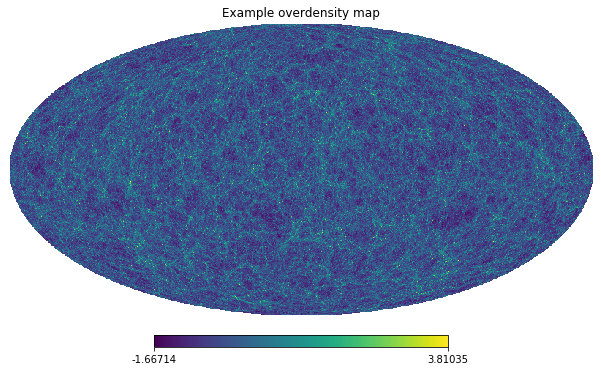

In [5]:
hp.mollview(np.log(overdensity_array[1] + 1), title='Example overdensity map')

# Calculate lensing convergence

### Define source galaxy plane 

In [6]:
source_edge_index = 20
z_source = z_bin_edges[source_edge_index]
print(z_source)

1.5345


### Define the centres of the comoving overdensity shells

In [7]:
comoving_edges =  cosmo_taka.comoving_distance(z_bin_edges)

(Text(0.5, 0, 'D comoving'), Text(0, 0.5, 'z'))

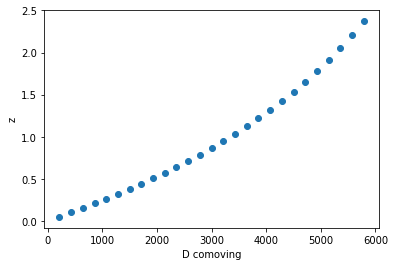

In [8]:
plt.scatter(comoving_edges,z_bin_edges)
plt.xlabel('D comoving'), plt.ylabel('z')

### Calculate the redshift at the centre of the comoving shells

In [9]:
z_centre = np.empty((len(comoving_edges)-1))
for i in range(len(comoving_edges)-1):
    z_centre[i] = z_at_value(cosmo_taka.comoving_distance,
                             0.5*(comoving_edges[i]+comoving_edges[i+1]))

### Define prefactor in lensing integral

In [10]:
kappa_pref_evaluated = br.kappa_prefactor(cosmo_taka.H0, cosmo_taka.Om0, length_unit = 'Mpc')

### Define an octant mask for this example

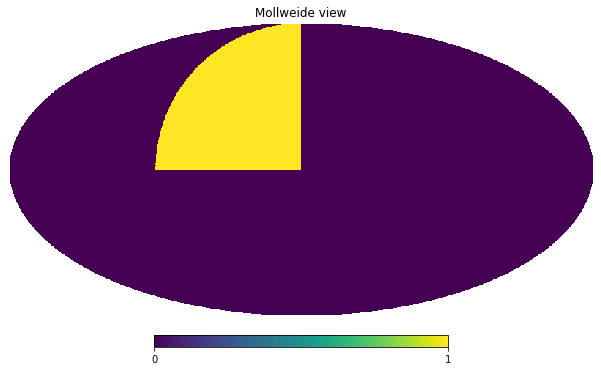

In [11]:
dec_pixels, ra_pixels = hp.pix2ang(512, range(512*512*12))
mask_boolean = (dec_pixels < np.pi*0.5)&(ra_pixels<0.5*np.pi)*(ra_pixels > 0)
mask_octant = np.where(mask_boolean==True,1.,0.)
hp.mollview(mask_octant)

### Use raytrace_integration function for single source galaxy plane

In [13]:
map_kappa = br.raytrace_integration(kappa_prefactor=kappa_pref_evaluated,
                                    overdensity_array=overdensity_array[:source_edge_index].T,
                                    a_centre=1./(1.+z_centre[:source_edge_index]),
                                    comoving_edges=cosmo_taka.comoving_distance(z_bin_edges)[:(source_edge_index+1)])

print(np.mean(map_kappa))

8.271818393309932e-07


# Compare with Takahashi example (which used GRayTrix)

In [13]:
kappa_taka_test = hp.ud_grade(fits.open('takahashi_mock_example/k_1024_'+str(source_edge_index+1)+\
                                        '.fits')[1].data['field'],512)

kappa_taka_test = kappa_taka_test*mask_octant

### Smooth maps for visualisation

In [14]:
smooth_map_kappa = hp.smoothing(map_kappa*mask_octant, sigma=np.deg2rad(5./60), verbose=False)
smooth_map_taka = hp.smoothing(kappa_taka_test*mask_octant, sigma=np.deg2rad(5./60), verbose=False)

/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


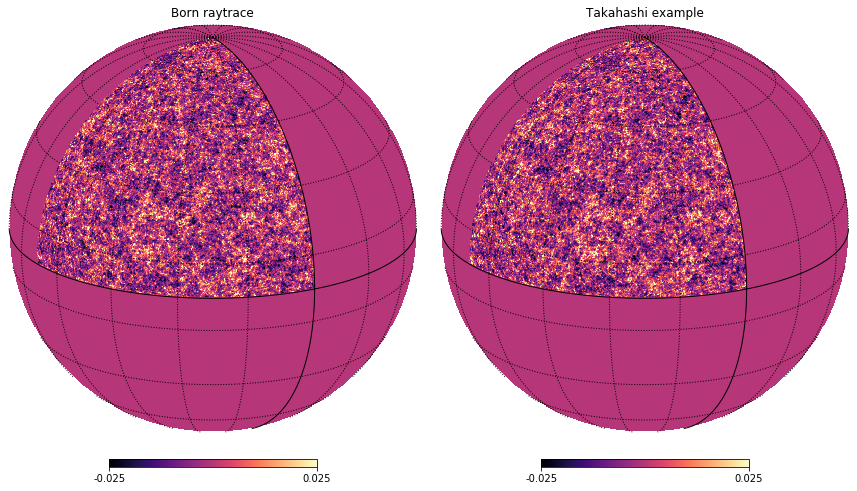

In [15]:
_ = plt.figure(figsize=(12,7))
_ = hp.visufunc.orthview(smooth_map_kappa, min=-0.025, max=0.025,
                     title='Born raytrace', half_sky=True,sub=(1,2,1),
                     rot = (30,20), cmap='magma')
_ = hp.visufunc.orthview(smooth_map_taka, min=-0.025, max=0.025,
                     title='Takahashi example', half_sky=True,sub=(1,2,2),
                     rot = (30,20), cmap='magma')
_ = hp.graticule(True, verbose=False)

### Compare with angular power spectrum (factor of 8 for sky fraction:  $1/f_{sky}$)

In [16]:
cell_kappa = 8. * hp.anafast(map_kappa*mask_octant, lmax=1024)
cell_kappa_taka = 8. *  hp.anafast(kappa_taka_test*mask_octant, lmax=1024)
cell = np.arange(len(cell_kappa))

In [17]:
ell_t, cl_t = np.load('takahashi_mock_example/cl_example.npy')
kappa_synfast = hp.synfast(cl_t, nside=1024)
cl_t_corrected = hp.anafast(hp.ud_grade(kappa_synfast,512), lmax=1024)

/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


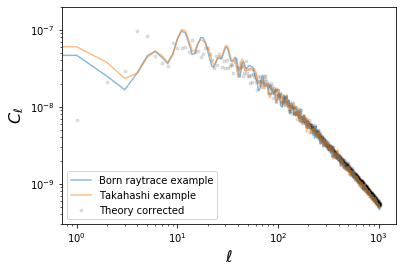

In [19]:
plt.loglog(range(len(cell_kappa)), cell_kappa,label='Born raytrace example', alpha=0.5)
plt.loglog(range(len(cell_kappa)), cell_kappa_taka,label='Takahashi example', alpha=0.5)
plt.scatter(range(len(cell_kappa)), cl_t_corrected, label='Theory corrected',
            alpha=0.1, marker='.', c='black')
plt.ylim(3e-10,2e-7), plt.legend()
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)
plt.savefig('plots/cell_test_theory.png', dpi=300)